# Section 1: Import Packages

In [117]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping,ModelCheckpoint
import random
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

# Section 2: Data Preprocessing

### Tumor Classification

In [4]:
path='./Data'
pd.DataFrame(os.listdir(path),columns=['Files'])

,Files
0,.DS_Store
1,meningioma_tumor
2,glioma_tumor
3,pituitary_tumor
4,normal


### Data Splitting (70% for training, 20% for validation)


In [5]:
data_directory = "./Original_Data"

# Create a TensorFlow dataset
batch_size = 32
image_size = (224,224) # For VGG-16
validation_split = 0.2

# Create a training set
train = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split=validation_split,  
    subset="training",
    seed=123,  
    image_size=image_size,
    batch_size=batch_size,
)

# Create a validation and test set
validation = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,  
    subset="validation",
    seed=123, 
    image_size=image_size,
    batch_size=batch_size,
)

Found 3096 files belonging to 4 classes.
Using 2477 files for training.
Found 3096 files belonging to 4 classes.
Using 619 files for validation.


### Class names

In [6]:
class_names = train.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

### Image Examples

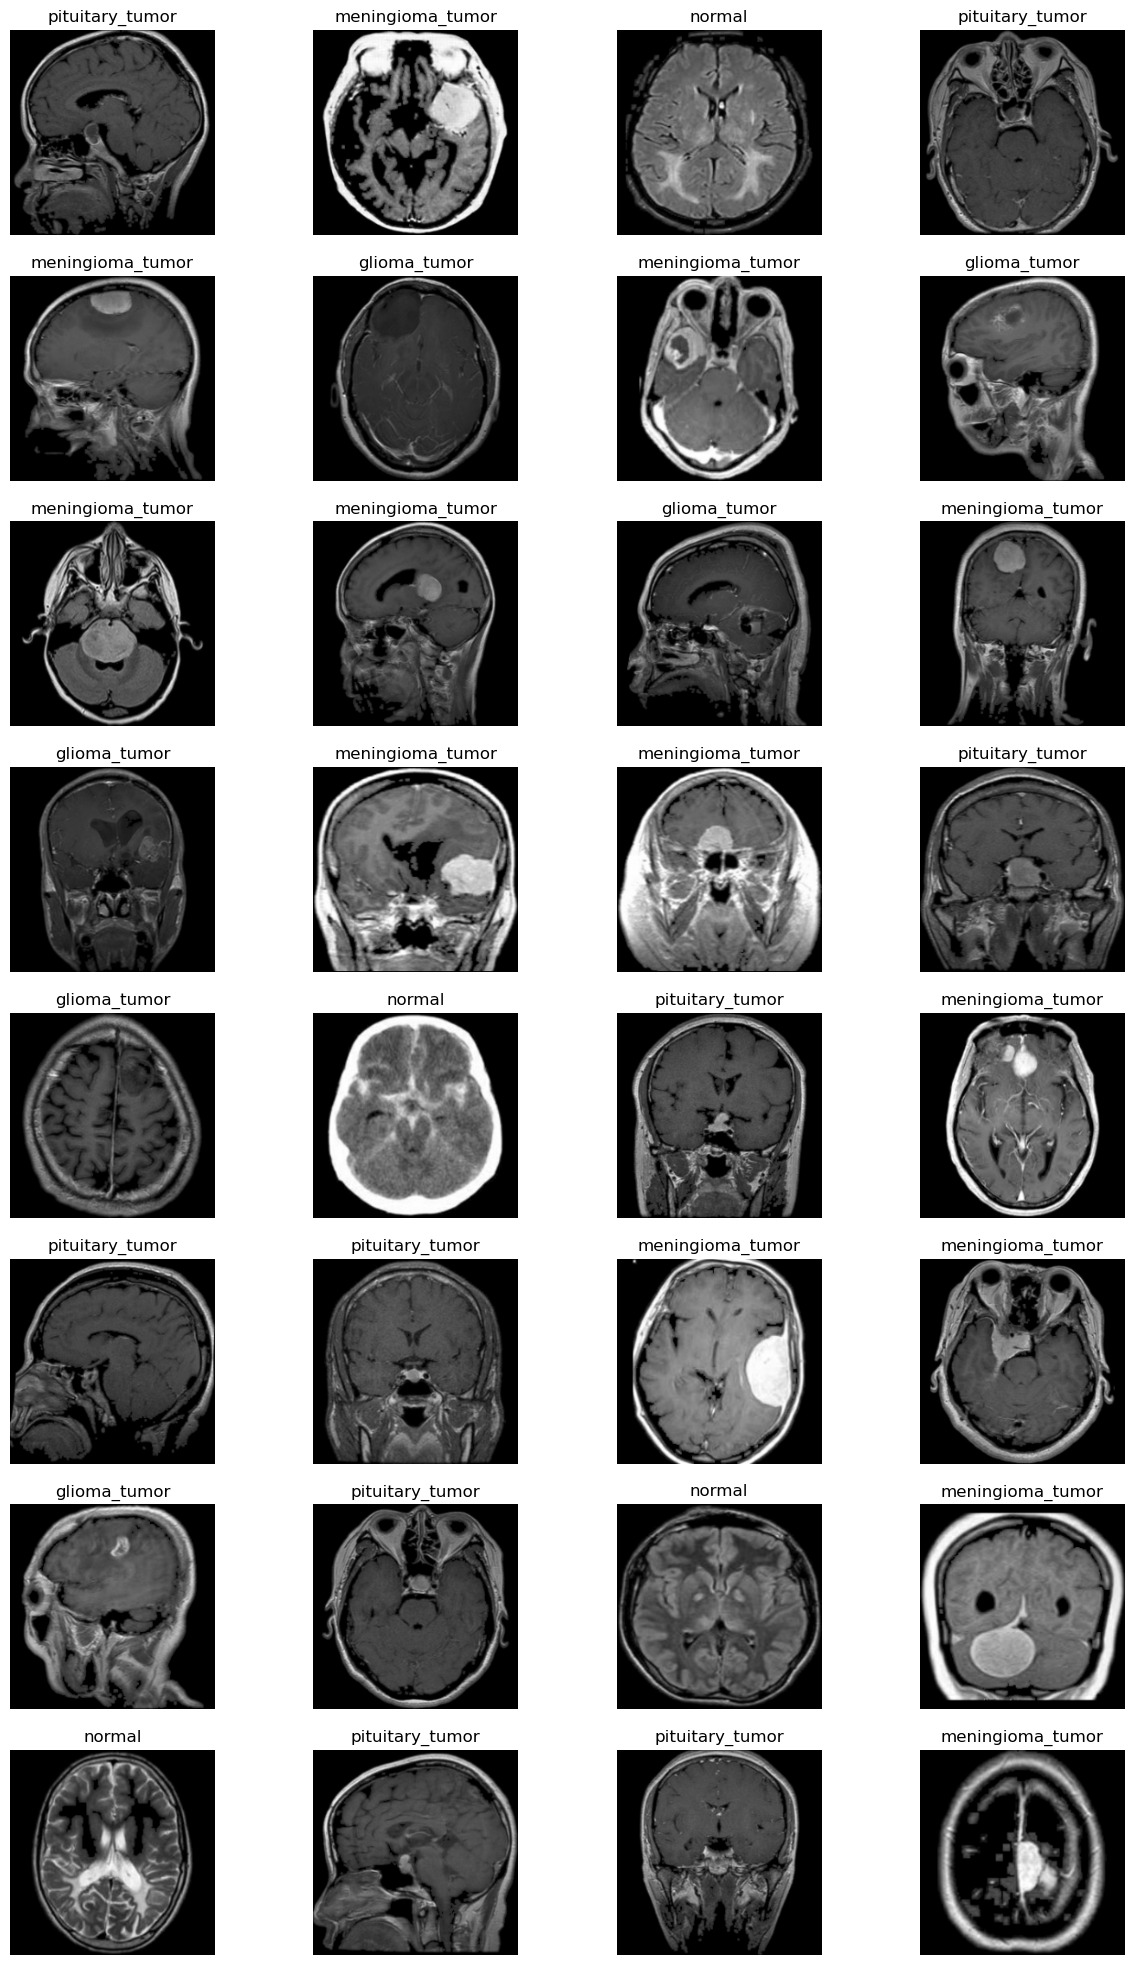

In [7]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1): # iterate over the 1st batch in train set
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        

# Section 3: Building and Training Model

### Early Stopping


In [8]:
def checkpoint_cb(model_name):
    filename = model_name + ".h5"
    cp = ModelCheckpoint(filename, save_best_only=True)
    return cp

early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)

## Building Model From Scratch

### Initialization

In [9]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=[224,224,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=32,activation='relu'))
cnn.add(tf.keras.layers.Dense(units=16,activation='relu'))
cnn.add(tf.keras.layers.Dense(units=4,activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

### Visualization

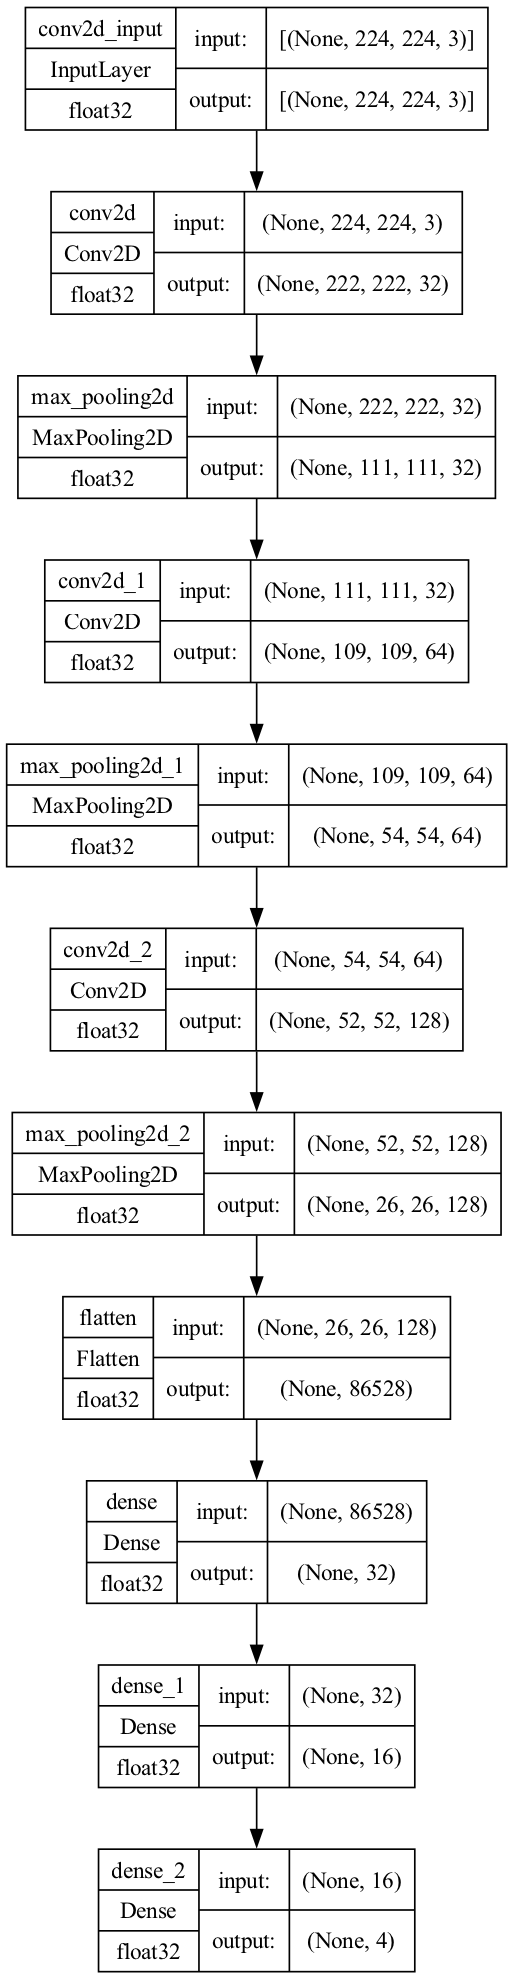

In [149]:
tf.keras.utils.plot_model(cnn, to_file='cnn.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

### Training

In [25]:
cnn.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics = ['accuracy']
)

hist = cnn.fit(train, validation_data = validation, epochs = 50, callbacks=[checkpoint_cb("cnn"),early_stopping_cb])

Epoch 1/50
78/78 [==============================] - 35s 447ms/step - loss: 0.4338 - accuracy: 0.8365 - val_loss: 1.2869 - val_accuracy: 0.6494
Epoch 2/50
78/78 [==============================] - 31s 400ms/step - loss: 0.3064 - accuracy: 0.8914 - val_loss: 1.0560 - val_accuracy: 0.7544
Epoch 3/50
78/78 [==============================] - 31s 394ms/step - loss: 0.2067 - accuracy: 0.9257 - val_loss: 1.1650 - val_accuracy: 0.7351
Epoch 4/50
78/78 [==============================] - 34s 431ms/step - loss: 0.1492 - accuracy: 0.9499 - val_loss: 1.1768 - val_accuracy: 0.7706
Epoch 5/50
78/78 [==============================] - 39s 493ms/step - loss: 0.1407 - accuracy: 0.9524 - val_loss: 1.3424 - val_accuracy: 0.7658
Epoch 6/50
78/78 [==============================] - 35s 448ms/step - loss: 0.1687 - accuracy: 0.9431 - val_loss: 1.4384 - val_accuracy: 0.7286
Epoch 7/50
78/78 [==============================] - 31s 400ms/step - loss: 0.1377 - accuracy: 0.9592 - val_loss: 1.4374 - val_accuracy: 0.7464

## VGG 16 Model

### Initialization

In [12]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
vgg16_model=tf.keras.models.Sequential()
vgg16_model.add(base_model)
vgg16_model.add(tf.keras.layers.Flatten()) 
vgg16_model.add(tf.keras.layers.Dropout(.5))
vgg16_model.add(tf.keras.layers.Dense(4,activation=tf.nn.softmax))
vgg16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 4)                 100356    
                                                                 
Total params: 14815044 (56.51 MB)
Trainable params: 100356 (392.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### Visualization

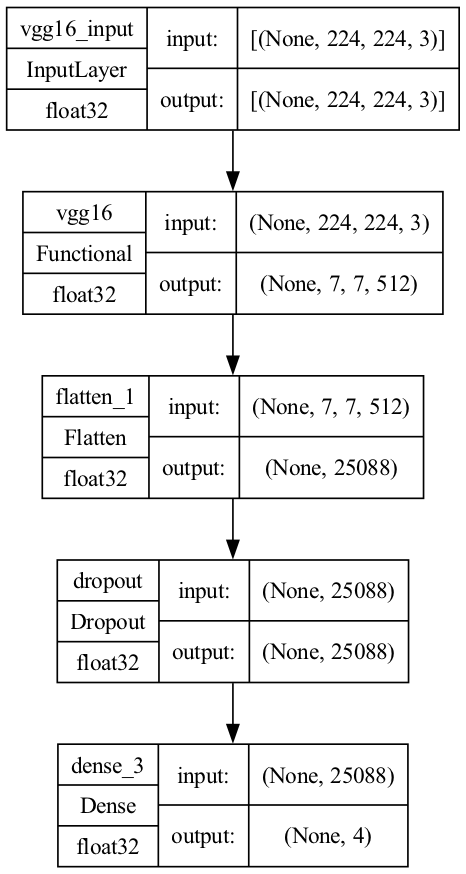

In [150]:
tf.keras.utils.plot_model(vgg16_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

### Training

In [14]:
vgg16_model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

vgg16_hist=vgg16_model.fit(train,epochs=20,validation_data=validation,callbacks=[checkpoint_cb("vgg16"),early_stopping_cb])

Epoch 1/20
78/78 [==============================] - 233s 3s/step - loss: 7.4721 - accuracy: 0.6924 - val_loss: 3.0336 - val_accuracy: 0.8433
Epoch 2/20


/Users/chuongtran/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 229s 3s/step - loss: 2.7361 - accuracy: 0.8652 - val_loss: 2.6792 - val_accuracy: 0.8837
Epoch 3/20
78/78 [==============================] - 229s 3s/step - loss: 1.5516 - accuracy: 0.9140 - val_loss: 2.9609 - val_accuracy: 0.8772
Epoch 4/20
78/78 [==============================] - 229s 3s/step - loss: 1.0181 - accuracy: 0.9326 - val_loss: 2.4073 - val_accuracy: 0.8998
Epoch 5/20
78/78 [==============================] - 229s 3s/step - loss: 1.3568 - accuracy: 0.9366 - val_loss: 3.5575 - val_accuracy: 0.8901
Epoch 6/20
78/78 [==============================] - 229s 3s/step - loss: 1.1008 - accuracy: 0.9479 - val_loss: 2.5139 - val_accuracy: 0.9144
Epoch 7/20
78/78 [==============================] - 229s 3s/step - loss: 0.8210 - accuracy: 0.9616 - val_loss: 4.0773 - val_accuracy: 0.8918
Epoch 8/20
78/78 [==============================] - 229s 3s/step - loss: 0.9031 - accuracy: 0.9544 - val_loss: 3.8450 - val_accuracy: 0.9079
Epoch 9/20
78/78 [======

## VGG 19

### Initialization

In [15]:
vgg19_base_model = tf.keras.applications.VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg19_base_model.trainable = False

vgg19_model = tf.keras.models.Sequential()
vgg19_model.add(vgg19_base_model)
vgg19_model.add(tf.keras.layers.Flatten())
vgg19_model.add(tf.keras.layers.Dropout(0.5))
vgg19_model.add(tf.keras.layers.Dense(4, activation=tf.nn.softmax))

vgg19_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 4)                 100356    
                                                                 
Total params: 20124740 (76.77 MB)
Trainable params: 100356 (392.02 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


### Visualization

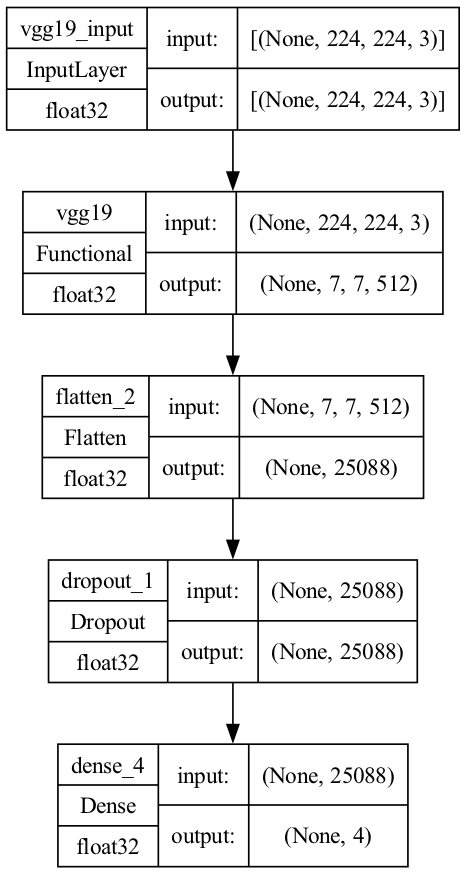

In [151]:
tf.keras.utils.plot_model(vgg19_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

### Training

In [17]:
vgg19_model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

vgg19_hist=vgg19_model.fit(train,epochs=20,validation_data=validation,callbacks=[checkpoint_cb("vgg19"),early_stopping_cb])

Epoch 1/20
78/78 [==============================] - 440s 6s/step - loss: 6.8821 - accuracy: 0.6681 - val_loss: 5.0664 - val_accuracy: 0.7803
Epoch 2/20


/Users/chuongtran/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 294s 4s/step - loss: 2.3227 - accuracy: 0.8603 - val_loss: 2.6643 - val_accuracy: 0.8320
Epoch 3/20
78/78 [==============================] - 320s 4s/step - loss: 1.9144 - accuracy: 0.8813 - val_loss: 2.3501 - val_accuracy: 0.8691
Epoch 4/20
78/78 [==============================] - 309s 4s/step - loss: 1.1245 - accuracy: 0.9193 - val_loss: 2.9310 - val_accuracy: 0.8918
Epoch 5/20
78/78 [==============================] - 345s 4s/step - loss: 0.8650 - accuracy: 0.9358 - val_loss: 4.1248 - val_accuracy: 0.8659
Epoch 6/20
78/78 [==============================] - 320s 4s/step - loss: 0.8265 - accuracy: 0.9435 - val_loss: 2.9813 - val_accuracy: 0.8853
Epoch 7/20
78/78 [==============================] - 330s 4s/step - loss: 0.7053 - accuracy: 0.9540 - val_loss: 4.0265 - val_accuracy: 0.8966
Epoch 8/20
78/78 [==============================] - 311s 4s/step - loss: 0.8639 - accuracy: 0.9451 - val_loss: 2.7736 - val_accuracy: 0.9079


## ResNet V2 50

### Initialization

In [18]:
resnet_base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
resnet_base_model.trainable = False

resnet_base_model.trainable = False

resnet_model = tf.keras.models.Sequential()
resnet_model.add(resnet_base_model)

resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(256, activation='relu'))
resnet_model.add(tf.keras.layers.Dropout(0.5))
resnet_model.add(tf.keras.layers.Dense(4, activation='softmax'))

### Visualization

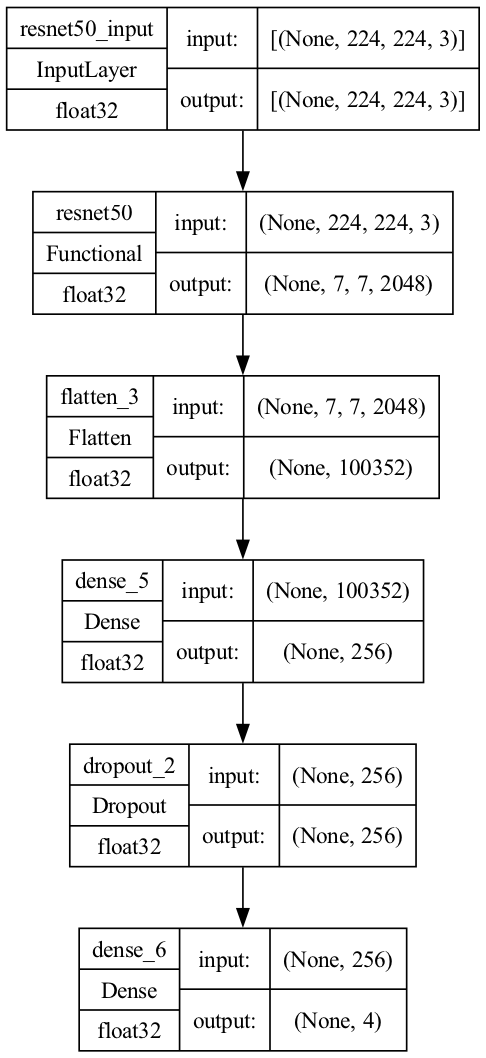

In [152]:
tf.keras.utils.plot_model(resnet_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

### Training

In [20]:
resnet_model.compile(optimizer ='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

resnet_hist=resnet_model.fit(train,epochs=20,validation_data=validation,callbacks=[checkpoint_cb("resnet"),early_stopping_cb])

Epoch 1/20
78/78 [==============================] - ETA: 0s - loss: 9.3632 - accuracy: 0.5898

/Users/chuongtran/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 89s 1s/step - loss: 9.3632 - accuracy: 0.5898 - val_loss: 0.6299 - val_accuracy: 0.7124
Epoch 2/20
78/78 [==============================] - 82s 1s/step - loss: 0.7298 - accuracy: 0.7081 - val_loss: 0.5846 - val_accuracy: 0.7868
Epoch 3/20
78/78 [==============================] - 73s 937ms/step - loss: 0.6544 - accuracy: 0.7521 - val_loss: 0.4845 - val_accuracy: 0.8368
Epoch 4/20
78/78 [==============================] - 70s 902ms/step - loss: 0.5523 - accuracy: 0.7917 - val_loss: 0.5085 - val_accuracy: 0.8174
Epoch 5/20
78/78 [==============================] - 71s 911ms/step - loss: 0.5313 - accuracy: 0.7949 - val_loss: 0.3450 - val_accuracy: 0.8643
Epoch 6/20
78/78 [==============================] - 70s 899ms/step - loss: 0.4852 - accuracy: 0.8111 - val_loss: 0.3590 - val_accuracy: 0.8562
Epoch 7/20
78/78 [==============================] - 71s 910ms/step - loss: 0.4436 - accuracy: 0.8159 - val_loss: 0.3975 - val_accuracy: 0.8837
Epoch 8/20
78/78

# Section 5: Evaluating the CNN

## Self-built Model

### Making a single prediction

Result: pituitary_tumor
1/1 [==============================] - 0s 49ms/step
3
Result:  pituitary_tumor


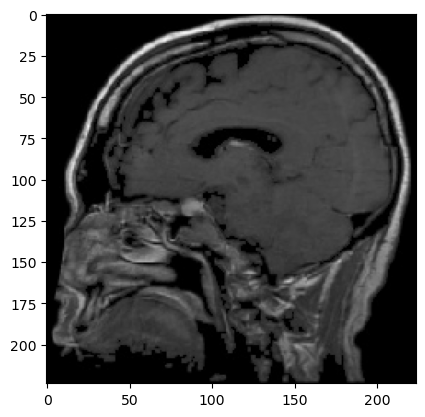

In [22]:
image_type = "pituitary_tumor" 

single_prediction_pituitary_path = os.path.join("./Test", image_type)

all_files = os.listdir(single_prediction_pituitary_path)

image_files = [f for f in all_files if f.lower().endswith(( '.jpg'))]

# Check if there are any image files in the folder
if len(image_files) == 0:
    print("No image files found in the folder.")
else:
    # Choose a random image file
    random_image = random.choice(image_files)
    print("Result:", image_type)
    

    random_image_path = os.path.join(single_prediction_pituitary_path, random_image)


test_img = image.load_img(random_image_path, target_size=(224,224))
plt.imshow(test_img)
test_img = image.img_to_array(test_img)

# We train the CNN based on batch so we need to convert test_img into batch (adding 1 more dimension)
test_img = np.expand_dims(test_img, axis=0)

model_predict = tf.nn.softmax(cnn.predict(test_img))
class_index = np.argmax(model_predict.numpy())

print(class_index)

print("Result: ", class_names[class_index])

### Evaluation

In [118]:
score, acc = cnn.evaluate(validation)
print('Validation Loss =', score)
print('Validation Accuracy =', acc)

20/20 [==============================] - 3s 129ms/step - loss: 1.0560 - accuracy: 0.7544
Validation Loss = 1.0560065507888794
Validation Accuracy = 0.7544426321983337


### Confusion Matrix and F1 Score

In [119]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=cnn.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))

20/20 [==============================] - 2s 113ms/step


In [120]:
cnn_precision = precision_score(y_val, y_pred, average='weighted') 
cnn_recall = recall_score(y_val, y_pred, average='weighted')

In [121]:
cnn_f1 = f1_score(y_val, y_pred, average='weighted')
print('F1 Score =', cnn_f1)

F1 Score = 0.7553229786737794


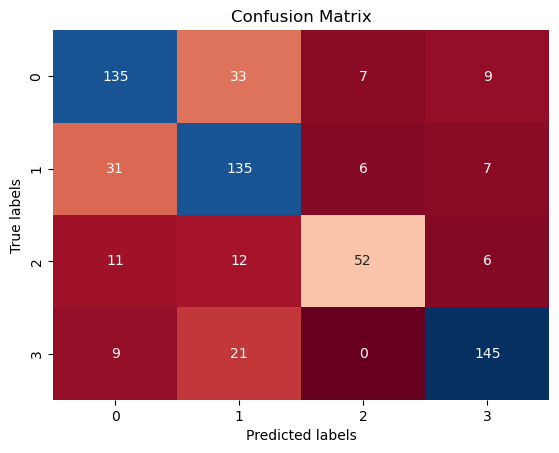

In [122]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()

### Training History

In [123]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.433823,0.836496,1.286878,0.649435
1,0.306394,0.891401,1.056007,0.754443
2,0.206733,0.925717,1.165009,0.735057
3,0.149217,0.949939,1.176839,0.770598
4,0.140669,0.952362,1.342383,0.765751
5,0.168738,0.943076,1.438392,0.728594
6,0.137725,0.959225,1.437420,0.746365


### Plot

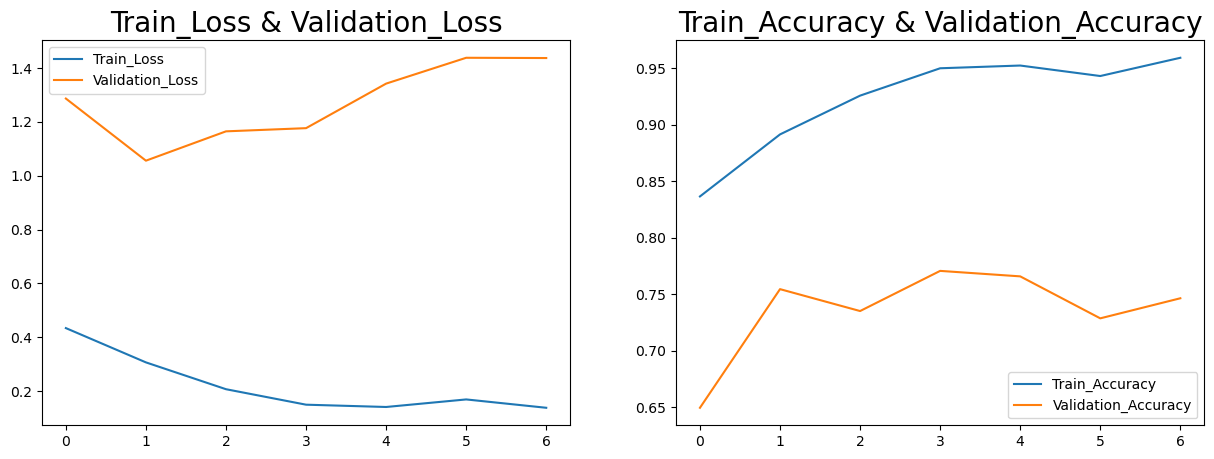

In [124]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

## VGG 16 Model

### Evaluation

In [125]:
score, acc = vgg16_model.evaluate(validation)
print('Validation Loss =', score)
print('Validation Accuracy =', acc)

20/20 [==============================] - 46s 2s/step - loss: 2.4073 - accuracy: 0.8998
Validation Loss = 2.4073469638824463
Validation Accuracy = 0.8998384475708008


### Confusion Matrix and F1 Score

In [126]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=vgg16_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))

20/20 [==============================] - 47s 2s/step


In [127]:
vgg16_precision = precision_score(y_val, y_pred, average='weighted') 
vgg16_recall = recall_score(y_val, y_pred, average='weighted')

In [128]:
vgg16_f1 = f1_score(y_val, y_pred, average='weighted')  
print('F1 Score =', vgg16_f1)

F1 Score = 0.8997144039022599


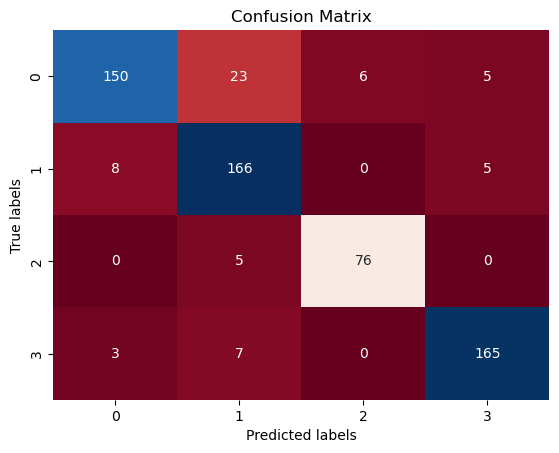

In [129]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()

### Training History

In [130]:
vgg16_hist_=pd.DataFrame(vgg16_hist.history)
vgg16_hist_

,loss,accuracy,val_loss,val_accuracy
0,7.472126,0.692370,3.033634,0.843296
1,2.736135,0.865159,2.679212,0.883683
2,1.551624,0.914009,2.960880,0.877221
3,1.018055,0.932580,2.407347,0.899838
4,1.356768,0.936617,3.557544,0.890145
5,1.100823,0.947921,2.513857,0.914378
6,0.821013,0.961647,4.077257,0.891761
7,0.903123,0.954380,3.845043,0.907916
8,0.672688,0.963262,4.674890,0.883683


### Plot

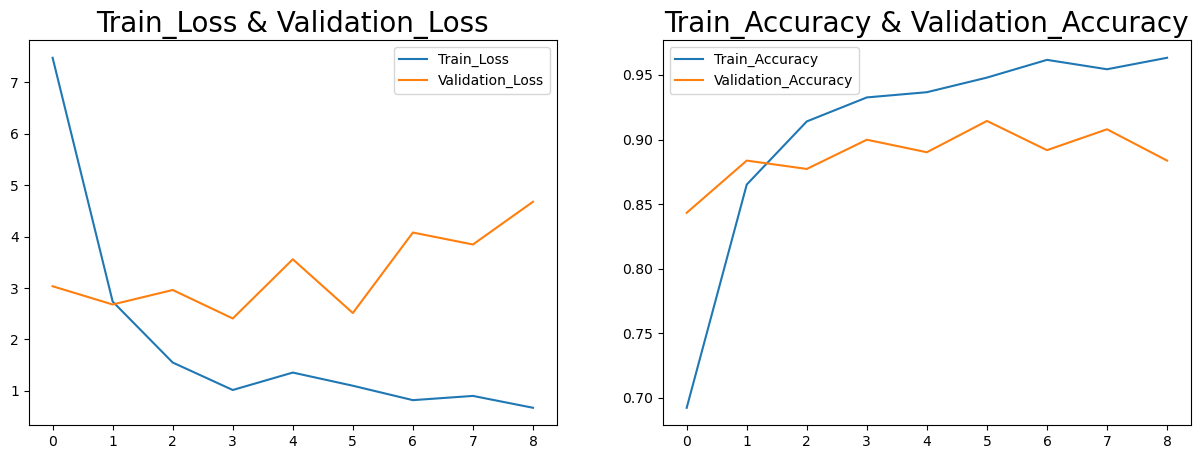

In [131]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(vgg16_hist_['loss'],label='Train_Loss')
plt.plot(vgg16_hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(vgg16_hist_['accuracy'],label='Train_Accuracy')
plt.plot(vgg16_hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

## VGG 19 Model

### Evaluation

In [132]:
score, acc = vgg19_model.evaluate(validation)
print('Validation Loss =', score)
print('Validation Accuracy =', acc)

20/20 [==============================] - 58s 3s/step - loss: 2.3501 - accuracy: 0.8691
Validation Loss = 2.350125551223755
Validation Accuracy = 0.8691437840461731


### Confusion Matrix and F1 Score

In [133]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=vgg19_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))

20/20 [==============================] - 60s 3s/step


In [134]:
vgg19_precision = precision_score(y_val, y_pred, average='weighted') 
vgg19_recall = recall_score(y_val, y_pred, average='weighted')

In [135]:
vgg19_f1 = f1_score(y_val, y_pred, average='weighted') 
print('F1 Score =', vgg19_f1)

F1 Score = 0.8698325340685668


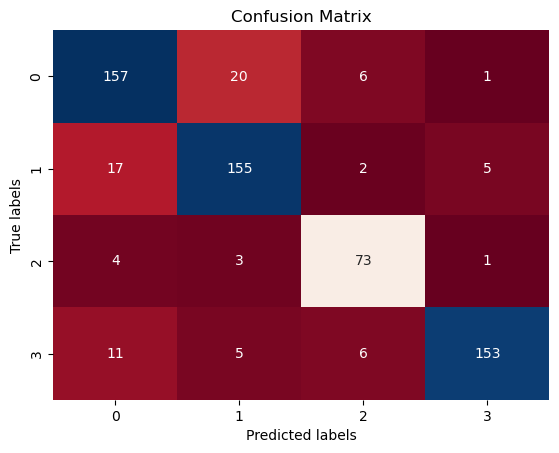

In [136]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()

### Training History

In [137]:
vgg19_hist_=pd.DataFrame(vgg19_hist.history)
vgg19_hist_

,loss,accuracy,val_loss,val_accuracy
0,6.882113,0.668147,5.066381,0.780291
1,2.322661,0.860315,2.664301,0.831987
2,1.914423,0.881308,2.350126,0.869144
3,1.124489,0.919257,2.930954,0.891761
4,0.865006,0.935809,4.124819,0.865913
5,0.826470,0.943480,2.981327,0.885299
6,0.705273,0.953977,4.026493,0.896607
7,0.863941,0.945095,2.773619,0.907916


### Plot


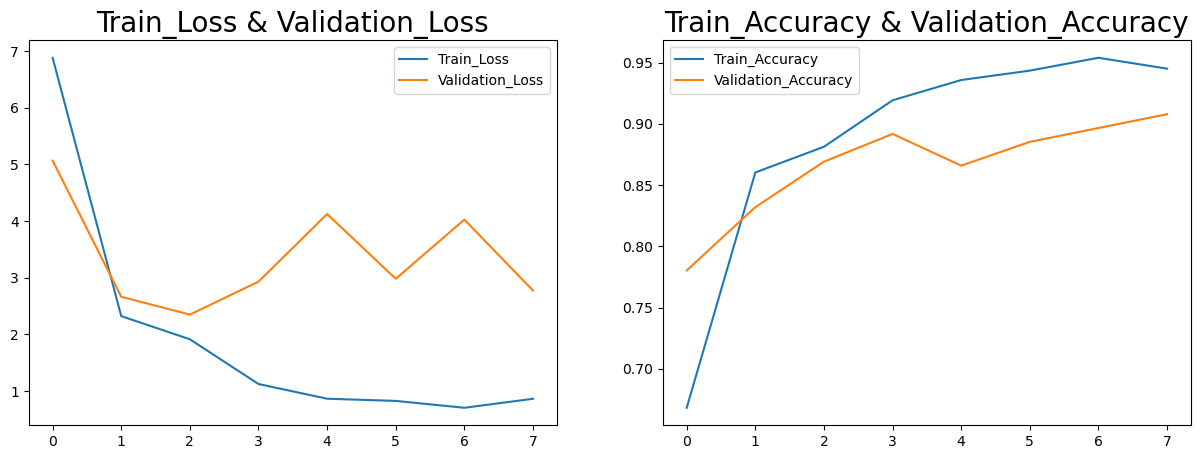

In [138]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(vgg19_hist_['loss'],label='Train_Loss')
plt.plot(vgg19_hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(vgg19_hist_['accuracy'],label='Train_Accuracy')
plt.plot(vgg19_hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

## ResNet V2 50

### Evaluation

In [139]:
score, acc = resnet_model.evaluate(validation)
print('Validation Loss =', score)
print('Validation Accuracy =', acc)

20/20 [==============================] - 14s 682ms/step - loss: 0.3159 - accuracy: 0.8885
Validation Loss = 0.31586554646492004
Validation Accuracy = 0.888529896736145


### Confusion Matrix and F1 Score

In [140]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=resnet_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))

20/20 [==============================] - 14s 680ms/step


In [141]:
resnet_precision = precision_score(y_val, y_pred, average='weighted') 
resnet_recall = recall_score(y_val, y_pred, average='weighted')

In [142]:
resnet_f1 = f1_score(y_val, y_pred, average='weighted')  
print('F1 Score =', resnet_f1)

F1 Score = 0.8880298878751086


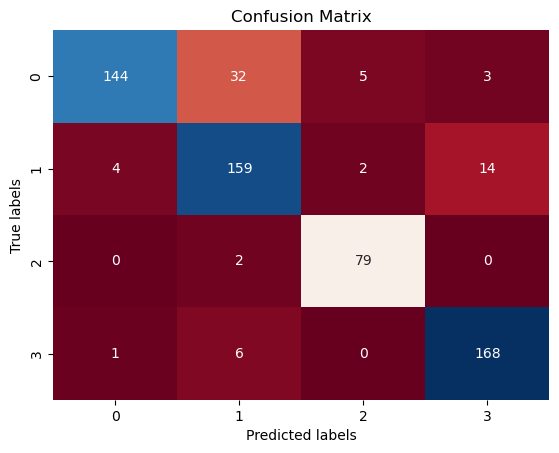

In [143]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()

### Training History

In [144]:
resnet_hist_=pd.DataFrame(resnet_hist.history)
resnet_hist_

,loss,accuracy,val_loss,val_accuracy
0,9.363210,0.589826,0.629851,0.712439
1,0.729790,0.708115,0.584616,0.786753
2,0.654440,0.752119,0.484505,0.836834
3,0.552312,0.791683,0.508538,0.817447
4,0.531285,0.794913,0.345026,0.864297
5,0.485154,0.811062,0.359007,0.856220
6,0.443576,0.815906,0.397486,0.883683
7,0.402341,0.833670,0.335746,0.890145
8,0.419671,0.832055,0.403574,0.882068
9,0.361923,0.846992,0.319864,0.885299


### Plot

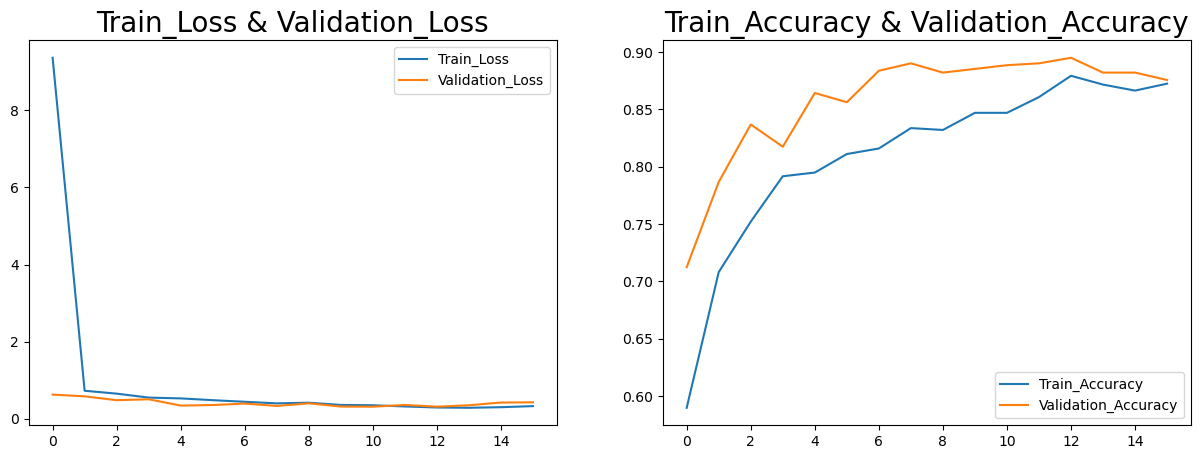

In [145]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(resnet_hist_['loss'],label='Train_Loss')
plt.plot(resnet_hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(resnet_hist_['accuracy'],label='Train_Accuracy')
plt.plot(resnet_hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

## Summary

### F1 Score

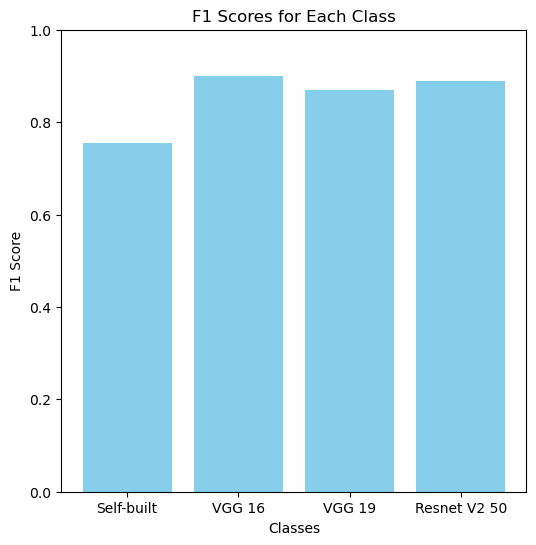

In [146]:
f1_scores = [cnn_f1, vgg16_f1, vgg19_f1, resnet_f1]
f1_class_names = ['Self-built', 'VGG 16', 'VGG 19', 'Resnet V2 50']

# Plotting a bar chart
plt.figure(figsize=(6, 6))
plt.bar(f1_class_names, f1_scores, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Class')
plt.ylim(0, 1)  # Set the y-axis range from 0 to 1
plt.show()

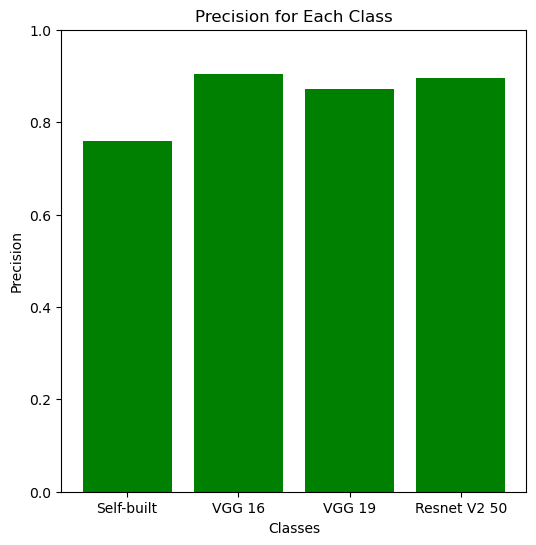

In [147]:
precision_scores = [cnn_precision, vgg16_precision, vgg19_precision, resnet_precision]
f1_class_names = ['Self-built', 'VGG 16', 'VGG 19', 'Resnet V2 50']


plt.figure(figsize=(6, 6))
plt.bar(f1_class_names, precision_scores, color='green')
plt.xlabel('Classes')
plt.ylabel('Precision')
plt.title('Precision for Each Class')
plt.ylim(0, 1)  
plt.show()

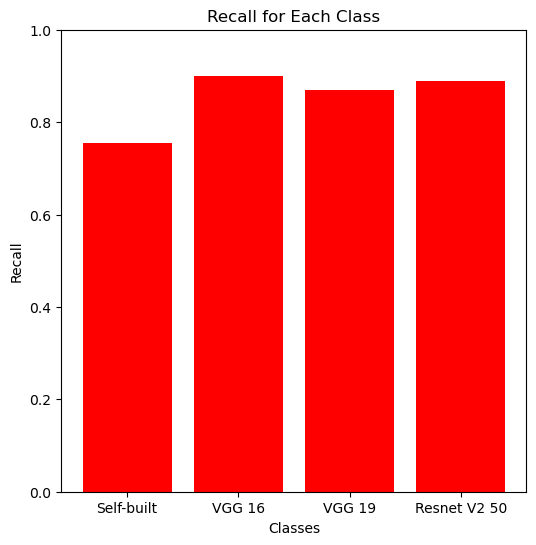

In [148]:
recall_scores = [cnn_recall, vgg16_recall, vgg19_recall, resnet_recall]
f1_class_names = ['Self-built', 'VGG 16', 'VGG 19', 'Resnet V2 50']

plt.figure(figsize=(6, 6))
plt.bar(f1_class_names, recall_scores, color='red')
plt.xlabel('Classes')
plt.ylabel('Recall')
plt.title('Recall for Each Class')
plt.ylim(0, 1)
plt.show()